In [1]:
# Initialization
!git clone "https://github.com/polito-EAD-2026/EAD26-U05.analisi-audio-tempo-frequenza.git"
!mv ./EAD26-U05.analisi-audio-tempo-frequenza/* .

Cloning into 'EAD26-U05.analisi-audio-tempo-frequenza'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 54 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 6.33 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (13/13), done.


# Autotune

In [2]:
!pip install -q librosa soundfile psola scipy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 69.3 MB/s eta 0:00:00


In [3]:
from functools import partial
from pathlib import Path
import argparse
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as sig
import psola
import IPython.display as ipd
import pandas as pd
import os
from scipy import signal

In [4]:
import matplotlib.pyplot as plt

"""
Example of usage:
import numpy as np
N, Fs, A, f = 10, 10, 0.5, 2
t = np.arange(N) / Fs
s = A * np.cos(2 * np.pi * f * t)
plot_vs_time(s,t, fmt='-*')
"""

def plot_vs_time(w, t, xlim=None, ylim=[-1, +1], fig=None, fmt='-'):
    """
    Plots a waveform versus time using matplotlib.
    Parameters:
        w (array-like): The waveform data to plot (y-axis values).
        t (array-like): The time values corresponding to the waveform (x-axis values).
        xlim (tuple, optional): Limits for the x-axis as (min, max). If None, uses the range of t.
        ylim (list or tuple, optional): Limits for the y-axis as [min, max]. Defaults to [-1, +1].
        fig (matplotlib.figure.Figure, optional): Existing figure to plot on. If None, creates a new figure.
        fmt (str, optional): Format string for the plot line (e.g., '-', '--', 'o'). Defaults to '-'.
    Returns:
        tuple: (fig, ax) where fig is the matplotlib Figure object and ax is the Axes object.
    Notes:
        - The function sets axis labels, grid, and tight layout for better appearance.
        - If no figure is provided, a new figure with size (12, 3) is created.
    """
    fig, ax = plt.subplots(figsize=(12,3)) if fig is None else fig
    ax.plot(t,w,fmt)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(xlim) if xlim is not None else plt.xlim(t[0],t[-1])
    ax.set_ylim(ylim) if ylim is not None else None
    fig.tight_layout()
    ax.grid(visible=True)

import numpy as np
import matplotlib.pyplot as plt

# plot frequency spectrum
def plot_vs_freq(X, f, Fs, type="linear", xlim=None, ylim=None, fig=None, zp=False, fmt="-"):

  fig, ax = plt.subplots(figsize=(6,3)) if fig is None else fig
  xlim = [np.min(f), np.max(f)] if xlim is None else xlim

  if type == "linear":
    ax.set_ylabel('Magnitude')
    ylim = [0, 1.2] if ylim is None else ylim
    X = X
  elif type == "log":
    ax.set_ylabel('Power (dBFS)')
    ylim = [-60, +6] if ylim is None else ylim
    X = 10*np.log10(X**2)

  ax.plot(f, X, fmt)
  ax.set_xlabel('Frequency (Hz)')

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  plt.grid(visible=True);
  plt.tight_layout()

# plot_vs_freq(x, Fs, N)
# plot_vs_freq(x, Fs, N, xlim=[2, 5], ylim=[-10, 3])

import numpy as np

def dft(x, Fs, N=None):
  L = len(x)
  N = L if N is None else N
  X = np.fft.rfft(x, N)
  X_ = np.abs(X) / (L/2)
  freq = np.fft.rfftfreq(N, d=1./Fs)
  # X_ = X_[:N//2+1]
  # freq = freq[:N//2+1]
  # X_dBFS = 20*np.log10(X_)
  return X_, freq

def normalize(x):
  return x / np.max(np.abs(x))

def RMS(x):
  return np.sqrt(np.mean(x**2))

def dBFS(x):
  return 20*np.log10(RMS(x)+np.finfo(float).eps)


def pad_to_multiple(array, multiple):
  length = len(array)
  target = ((length + multiple - 1) // multiple) * multiple
  return np.pad(array, (0, target - length), mode='constant')

def time_framing_fn(x, L, H, win=None, fn=np.max):

  win = signal.windows.boxcar(L) if win is None else win # rectangular y = pad_to_multiple(x,L)
  y = pad_to_multiple(x,L)

  i_v = np.arange(0, len(y) - L+1, H) # index of first sample of each frame (check last)
  # print(f"Last frame starts at {i_v[-1]} and ends at {i_v[-1]+L}. Input has length {len(y)}")

  n_frames = len(i_v) # number of frames

  # ---- allocate output by probing fn on the first frame ----
  first_frame = y[0:L] * win
  test_val = fn(first_frame)
  out_shape = np.shape(test_val)
  fn_v = np.zeros((n_frames,) + out_shape)
  # ----

  for n in range(n_frames):
    i = i_v[n]
    frame = y[ i : i+L ]
    frame_w = frame * win # windowed frame
    fn_v[n] = fn(frame_w)

  return (i_v, fn_v)


def round_to_even(x):
    return int(2 * round(x / 2))

def plot_vs_time_freq(X, f, t, ylim=None, fig=None):

  fig, ax = plt.subplots(figsize=(12,6)) if fig is None else fig

  ylim = [np.min(Xf), np.max(Xf)] if ylim is None else ylim

  # adapt dBs to STFT computation +6 and 80 dB delta max
  XvdB = 20*np.log10(X)+6
  XvdB = np.maximum(XvdB, XvdB.max() - 80)

  ax.imshow(XvdB, origin='lower', aspect='auto', cmap="viridis", extent=[Xt[0], Xt[-1], Xf[0], Xf[-1]])
  ax.set_ylim(ylim)
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequency (Hz)')

  # plt.show()

## Functions

Overview of the functions:

* `pitch_to_scale(pitch, scale)`
Converts a single pitch value (Hz) to the closest scale degree by converting to MIDI, snapping to the nearest pitch class in the given scale, and converting back to Hz.

* `smooth_median(x, n)`
Applies median filtering to reduce jumps and outliers in the corrected pitch trajectory.

* `closest_pitch_from_scale(f0, scale)`
Vectorized version of the pitch-to-scale mapping over an array of fundamental frequency values.

* `midi_scale_range(note, scale, values)` extracts all MIDI notes belonging to a given musical scale within the range spanned by a set of observed pitch values. The function generates a mask that includes not only the scale degrees but also neighbors, allowing for visual padding when plotting pitch curves.

* `plot_pitch(fo, fm, t, y_ticks=None)` visualizes one or two pitch trajectories (in Hz) as MIDI note numbers over time. It provides an optional custom set of y-ticks, typically produced by midi_scale_range, to display scale degrees on the vertical axis.

In [5]:
def pitch_to_scale(pitch, scale):
    """
    Map a single pitch value (in Hz) to the closest pitch that belongs
    to the specified musical scale.

    This function converts the pitch to a MIDI note number, snaps its
    pitch class to the nearest degree of the given scale, and converts
    it back to Hz. NaN inputs are preserved.

    Parameters:
    - pitch: float
        Input pitch in Hz.
    - scale: str
        Musical scale name compatible with librosa (e.g. "C:maj").

    Returns:
    - float
        Corrected pitch in Hz, or NaN if input pitch is NaN.
    """

    # If the pitch is undefined, simply return NaN.
    if np.isnan(pitch):
        return np.nan

    # Convert scale name (e.g. "C:maj") to pitch-class degrees.
    degrees = librosa.key_to_degrees(scale)

    # Duplicate the lowest degree one octave higher (add +12 semitones).
    # Ensures correct wrapping for values slightly below the root.
    degrees = np.concatenate((degrees, [degrees[0] + 12]))

    # Convert input frequency to a fractional MIDI note number.
    midi_note = librosa.hz_to_midi(pitch)

    # Extract the pitch class (0–12 range).
    degree = midi_note % 12

    # Find the closest scale degree in semitone space.
    degree_id = np.argmin(np.abs(degrees - degree))

    # Compute how far the pitch class is from the target degree.
    degree_difference = degree - degrees[degree_id]

    # Correct the MIDI note by removing the difference.
    midi_note -= degree_difference

    # Convert back to frequency in Hz.
    return librosa.midi_to_hz(midi_note)


def smooth_median(x, n):
    """
    Apply median filtering to smooth a pitch trajectory.

    Median filtering helps remove outliers and sudden jumps often produced
    by pitch detection algorithms. NaN values in the input are preserved.

    Parameters:
    - x: array-like
        Input pitch contour.
    - n: int
        Kernel size for the median filter (ignored in current implementation).

    Returns:
    - array-like
        Smoothed version of the input pitch contour.
    """

    # Median-filter the sequence to remove small fluctuations.
    smoothed_x = sig.medfilt(x, kernel_size=11)

    # Preserve NaN values: if input had NaN, keep it in the output.
    smoothed_x[np.isnan(smoothed_x)] = x[np.isnan(smoothed_x)]

    return smoothed_x


def closest_pitch_from_scale(f0, scale):
    """
    Map an entire pitch contour to the closest pitches belonging
    to a specified musical scale.

    Each pitch value is independently mapped to the nearest scale degree
    using pitch_to_scale(), and thepitch-hopping is reduced with median filtering.

    Parameters:
    - f0: array-like
        Sequence of detected fundamental frequency values (Hz).
    - scale: str
        Target musical scale name (e.g. "C:maj").

    Returns:
    - array-like
        Pitch-corrected contour, aligned to the selected scale.
    """

    # Allocate an array with the same length as the input F0 vector.
    closest_pitch = np.zeros_like(f0)

    # Map each pitch individually to the closest degree of the scale.
    for i in np.arange(len(f0)):
        closest_pitch[i] = pitch_to_scale(f0[i], scale)

    # Apply smoothing to reduce abrupt jumps between degrees.
    return smooth_median(closest_pitch, 11)


def midi_scale_range(note, scale, values):
    """
    Compute the set of MIDI note numbers belonging to a given scale
    that fall within the pitch range defined by the input values.

    The range is determined from the minimum and maximum frequency
    in `values`, converted to MIDI. Scale degrees from the given root
    note are expanded across an octave, and only those falling within
    the range are retained. The mask is then expanded left and right
    to include neighboring degrees for more readable plot tick labels.

    Parameters:
    - note: str
        Root note as a string recognized by librosa (e.g., "C3", "Ab3").
    - scale: str
        Musical scale name compatible with librosa (e.g., "C:maj").
    - values: array-like
        Collection of pitch values in Hz from which min/max MIDI range is extracted.

    Returns:
    - array-like
        MIDI note numbers belonging to the scale, extended by one neighbor on each side.
    """

    # Convert min/max pitch (Hz) to MIDI limits.
    midi_min = int(np.floor(librosa.hz_to_midi(np.nanmin(values))))
    midi_max = int(np.ceil(librosa.hz_to_midi(np.nanmax(values))))

    # Convert scale degrees (0–11) and map them to the MIDI octave of `note`.
    degrees = librosa.key_to_degrees(scale)

    # Expand degrees over one octave and anchor them to the root note.
    degrees = librosa.note_to_midi(note) + np.sort(np.concatenate((degrees, degrees + 12)))

    # Select only degrees inside the min–max MIDI range.
    mask = (degrees >= midi_min) & (degrees <= midi_max)

    # Extend the mask one step left and right to include neighbors.
    extended_mask = mask.copy()
    extended_mask[:-1] |= mask[1:]   # extend to the left
    extended_mask[1:]  |= mask[:-1]  # extend to the right

    return degrees[extended_mask]


def plot_pitch(fo, fm, t, y_ticks=None):
    """
    Plot one or two pitch trajectories (in Hz) converted to MIDI notes.

    Parameters:
    - fo: array-like
        Primary pitch contour (Hz).
    - fm: array-like or None
        Optional second pitch contour for comparison (Hz).
    - t: array-like
        Time axis in seconds.
    - y_ticks: array-like or None
        Optional list of MIDI values to use as y-axis ticks (e.g., scale degrees).

    Returns:
    - None
        The function displays a matplotlib plot.
    """

    plt.subplots(figsize=(12, 4))

    # Convert fundamental pitch to MIDI and plot it.
    plt.plot(t, librosa.hz_to_midi(fo))

    # Plot the second pitch trajectory if supplied.
    if not fm is None:
        plt.plot(t, librosa.hz_to_midi(fm))

    plt.ylabel('MIDI note')
    plt.xlabel('Time (s)')
    # plt.legend(loc="lower right")
    plt.yticks(y_ticks)

    # Add grid lines for readability.
    plt.grid(visible=True)
    # plt.show()


## Analysis

Load the `./media/autotune/autotune-letitgo-bad.wav` audio file, listen to it and plot its waveform and spectrogram.

Use window length of 2048 samples (that at 48 kHz corrensponds to 42 ms, an overlap of 75%, and an Hann window.


Loaded ./media/autotune/autotune-letitgo-bad.wav with Fs:48000Hz and length:3.0912291666666665s


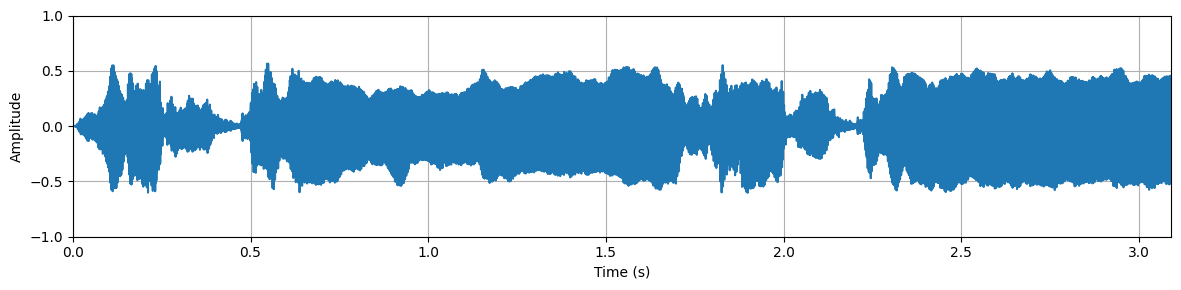

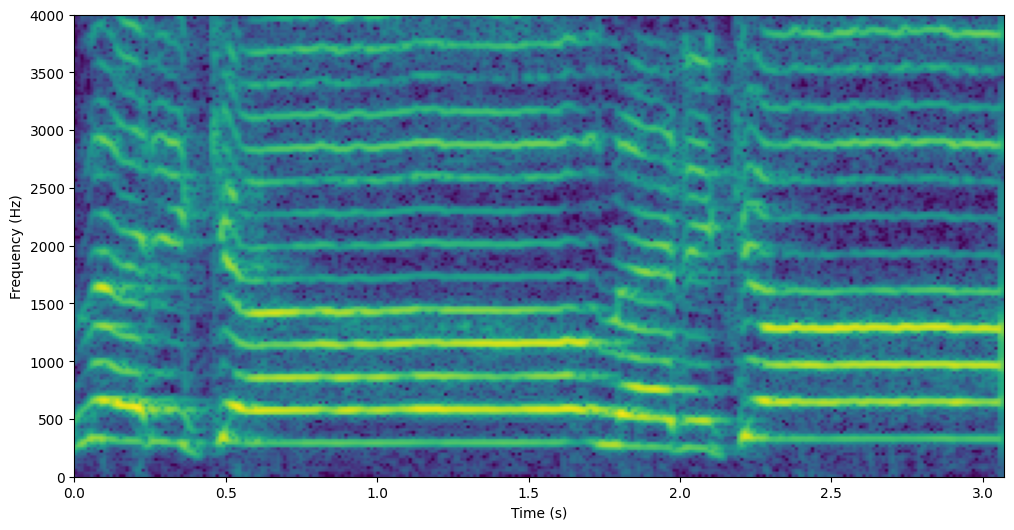

In [6]:
# Load audio and plot waveform and spectrogram #
################################################

filepath = './media/autotune/autotune-letitgo-bad.wav'

# Load the audio file, force mono.
x, Fs = librosa.load(filepath, sr=None, mono=True)
t = np.arange(len(x)) / Fs

print(f"Loaded {filepath} with Fs:{Fs}Hz and length:{np.max(t)}s")
ipd.display(ipd.Audio(x, rate=Fs))

# Plot the waveform.
plot_vs_time(x, t, xlim=None, ylim=[-1, +1], fig=None, fmt='-')
plt.show()

# Select frame lenght, hop-size and NFFT
L = 2048
H = L // 4
N = L
w = signal.windows.hann(L)
idxs, vals = time_framing_fn(x, L, H, win=w, fn=lambda x: dft(x,Fs,N))

Xf = np.array(vals[0][1])             # get frequencies
Xv = np.array([v[0] for v in vals]).T # get spectrogram
Xt = np.array(idxs) / Fs              # get time points

# Plot the spectrogram
plot_vs_time_freq(Xv, Xf, Xt, ylim=(0,4000))
plt.show()


## Pitch tracking

Using librosa PYIN method retrieve and plot the pitch of the provided audio file:

- use `librosa.pyin(y,frame_length=,hop_length=,sr=,fmin=,fmax=)` method to get the `f0` estimation from the signal

- use `librosa.times_like(X,sr=,hop_length=)` method to get the time values `time_points` that match the f0 values


See documentation and exaples at [https://librosa.org/doc/latest/generated/librosa.pyin.html](https://librosa.org/doc/latest/generated/librosa.pyin.html)

![img](https://github.com/polito-EAD-2026/EAD26-U05.analisi-audio-tempo-frequenza/blob/main/imgages/autotune-letitgo-bad.f0.png?raw=true)


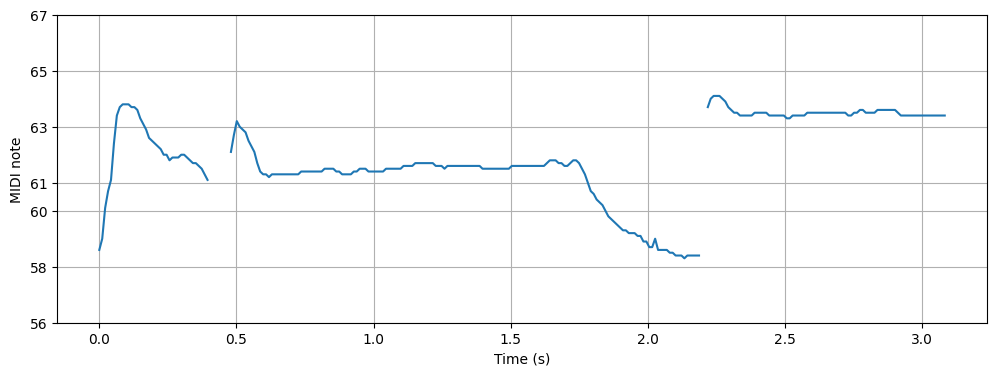

In [ ]:
# Pitch tracking using the PYIN algorithm #
###########################################

fmin = librosa.note_to_hz('C2')
fmax = librosa.note_to_hz('C7')

f0, voiced_flag, voiced_probabilities = # TODO: librosa.pyin
time_points = # TODO: librosa.times_like

# Plot pitch with plot_pitch function
#   y_ticks are defined as the notes of a major scale starting at Ab3
y_tics = midi_scale_range('Ab3', 'C:maj', f0)
plot_pitch(f0, None, time_points, y_tics)


## Test pitch change

Define your pitch track for each audio frame `[0:len(f0)]` and then apply `psola.vocode` algorithm to the audio file. Listen to the result and plot the original and modified pitch track.

- **fixed** `f0`: set all pitch values to a fixed frequency

- **vibrato** `f0`: use the `vibrato_curve(f0, t, depth_cents=100, rate_hz=5)` function to modulate the pitch with an oscillation of given *depth* (in cents) and *rate* in Hz

- **vline** `f0`: use the `map_pitches_to_timepoints(time_points, pitches)` function to define a vline of the pitch values

### PSOLA implementation

This PSOLA module is for constant- and variable-rate pitch-shifting and time-stretching of speech. It is a wrapper around the parselmouth wrapper around the Praat implementation of TD-PSOLA. Pitch-shifting is performed by providing a numpy array of target pitch values equally spaced over time. See [https://github.com/maxrmorrison/psola](https://github.com/maxrmorrison/psola).

**psola.vocode**
```
"""Performs pitch vocoding using Praat

Arguments
    audio : np.array(shape=(samples,))
        The speech signal to process
    sample_rate : int
        The audio sampling rate.
    source_alignment : pypar.Alignment
        The current alignment if performing time-stretching
    target_alignment : pypar.Alignment
        The target alignment if performing time-stretching
    target_pitch : np.array(shape=(frames,))
        The target pitch contour
    constant_stretch : float or None
        A constant value for time-stretching
    fmin : int
        The minimum allowable frequency in Hz.
    fmax : int
        The maximum allowable frequency in Hz.

Returns
    audio : np.array(shape=(samples,))
        The vocoded audio
"""
```

In [ ]:
# @title
def vibrato_curve(f0, t, depth_cents=100, rate_hz=5):
    """
    Apply a vibrato effect to a pitch contour.

    The vibrato is defined as a sinusoidal modulation of pitch, where the
    modulation depth is expressed in cents (1 semitone = 100 cents) and the
    modulation rate is given in Hz. The vibrato curve is generated by creating
    a sinusoid in the pitch domain and then converting cents to a multiplicative
    frequency factor.

    Parameters:
    - f0: array-like
        Base fundamental frequency contour (Hz) to which vibrato will be applied.
    - t: array-like
        Time values (seconds), same length as f0, used to evaluate the vibrato sinusoid.
    - depth_cents: float, optional
        Peak vibrato depth in cents. Default is 100 cents (one semitone).
    - rate_hz: float, optional
        Vibrato modulation frequency in Hz (cycles per second). Default is 5 Hz.

    Returns:
    - array-like
        Vibrato-modulated pitch contour (Hz), same shape as f0.
    """

    # Vibrato depth expressed in cents, modulated by a sinusoid over time.
    vibrato_cents = depth_cents * np.sin(2 * np.pi * rate_hz * t)

    # Convert cents to a multiplicative frequency factor: 1200 cents = 1 octave = factor 2.
    vibrato_factor = 2 ** (vibrato_cents / 1200)

    # Apply vibrato as a multiplicative deviation on the original frequency.
    return f0 * vibrato_factor

def map_pitches_to_timepoints(time_points, pitches):
    """
    Map pitch values to time points based on when they change.

    Given an array of time points and a list of pitch-change events,
    this function assigns to each time point the pitch active at that moment.
    Pitch values are held constant until the next change occurs.

    Parameters:
    - time_points: array-like
        Time grid on which pitch values should be computed.
    - pitches: list of (time, value) tuples
        Sorted list indicating when the pitch changes.

    Returns:
    - array-like
        Array of pitch values aligned to time_points.

    Example: returns pitch curve with 58 (midi) at 0s, 60 at 1s and 65 at 2.5s
    `map_pitches_to_timepoints(time_points, [ (0, 58), (1,60), (2.6, 65) ])`

    """

    # Separate times and values from pitches
    pitch_times = np.array([p[0] for p in pitches])
    pitch_values = np.array([p[1] for p in pitches])

    # For each time point, find which pitch index applies.
    indices = np.searchsorted(pitch_times, time_points, side='right') - 1

    # Clip to ensure we don't go below 0.
    indices = np.clip(indices, 0, len(pitch_values) - 1)

    # Map the indices to actual pitch values.
    result = pitch_values[indices]

    return result

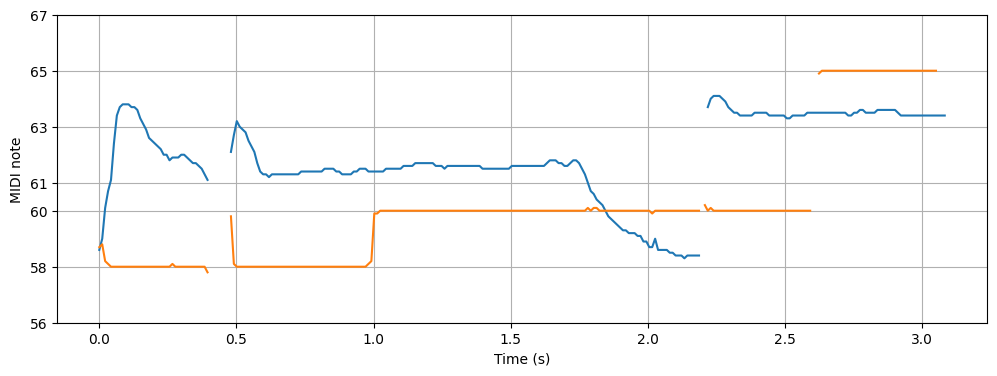

In [ ]:
# Test pitch change #
#####################

f0_mod = # TODO: new pitch track

# PSOLA
x_mod = # TODO: psola.vocode
ipd.display(ipd.Audio(x_mod, rate=Fs))

# Plot original and modified pitch with the plot_pitch function
#   f0: original pitch
#   f0_mod: modified pitch
y_tics = midi_scale_range('Ab3', 'C:maj', np.concatenate((f0,f0_mod)))
plot_pitch(f0, f0_mod, time_points, y_tics)

## Autotune (closest note in the scale)

Use the `closest_pitch_from_scale(f0,scale)` with scale equal to `'Ab:maj'` to map the real pitch of the audio file to the closest note in the scale.

Then apply the `psola.vocode` to the audio file to autotune the pitch.

![img](https://github.com/polito-EAD-2026/EAD26-U05.analisi-audio-tempo-frequenza/blob/main/imgages/autotune-letitgo-scale.f0.png?raw=true)

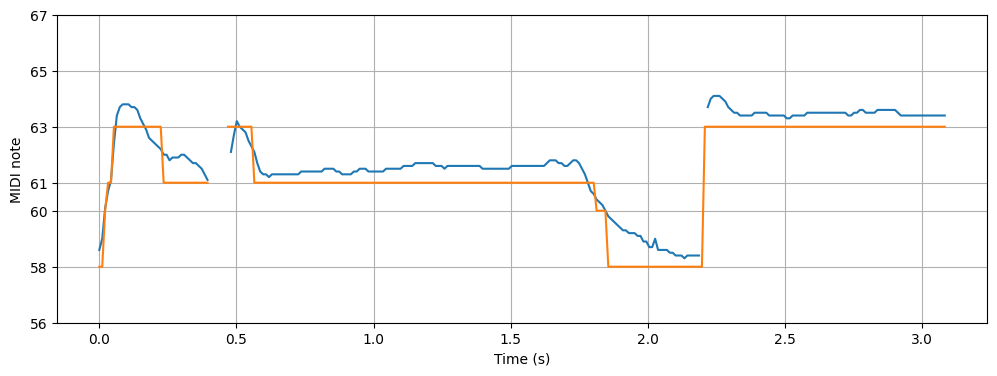

In [ ]:
# Autotune (closest note in the scale) #
########################################

f0_scale = closest_pitch_from_scale(f0, 'Ab:maj')



## Re-tune

Listen to a properly tuned audio file `./media/autotune/autotune-letitgo-good.wav` singing the same excerpt of the song. Then extract the good pitch track, apply it to the bad tuned audio file and listen to the fascinating result.

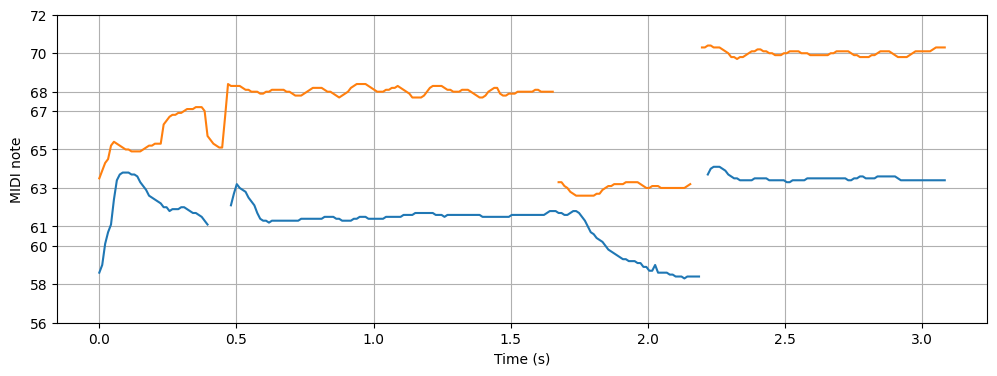

In [ ]:

# Load the audio file, force mono.
filepath = './media/autotune/autotune-letitgo-good.wav'
y, yFs = librosa.load(filepath, sr=None, mono=True)
ipd.display(ipd.Audio(y, rate=yFs))


# Pitch tracking using the PYIN algorithm.


# Plot the old and new pitch track


# Apply PSOLA


# Listen to the result
